### Imports

In [1]:
import pandas as pd
import datetime as dt

matches = pd.read_csv("matches.csv", index_col=0)

### Data Cleaning and Feature Engineering

In [2]:
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,15/08/2021,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,Match Report,NaN,18,4,16.9,1,0,0,2022,Manchester City
2,21/08/2021,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,...,Match Report,NaN,16,4,17.3,1,0,0,2022,Manchester City
3,28/08/2021,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,...,Match Report,NaN,25,10,14.3,0,0,0,2022,Manchester City
4,11/09/2021,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,...,Match Report,NaN,25,8,14.0,0,0,0,2022,Manchester City
6,18/09/2021,15:00,Premier League,Matchweek 5,Sat,Home,D,0,0,Southampton,...,Match Report,NaN,16,1,15.7,1,0,0,2022,Manchester City


In [3]:
matches.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team'],
      dtype='object')

In [4]:
matches.drop(["round", 
              "comp", 
              "season", 
              "attendance", 
              "notes", 
              "captain", 
              "formation", 
              "referee", 
              "match report", 
              "notes"], 
             axis=1, inplace=True)

In [5]:
matches["team"].value_counts()

Brighton and Hove Albion    72
West Ham United             72
Newcastle United            72
Manchester United           72
Southampton                 72
Wolverhampton Wanderers     71
Manchester City             71
Leeds United                71
Arsenal                     71
Burnley                     71
Tottenham Hotspur           71
Crystal Palace              71
Leicester City              70
Chelsea                     70
Everton                     70
Aston Villa                 70
Sheffield United            38
Liverpool                   38
Fulham                      38
West Bromwich Albion        38
Brentford                   34
Norwich City                33
Watford                     33
Name: team, dtype: int64

In [6]:
#convert categoric variables to numeric for machine learning model

In [7]:
matches["date"] = pd.to_datetime(matches["date"])

In [8]:
matches["venue_code"] = matches["venue"].astype("category").cat.codes

In [9]:
matches["day_code"] = matches["date"].dt.dayofweek

In [10]:
#retrieve just hour from ko time - time of day may affect performance
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype(int)

In [11]:
#create dict to rename teams so they match in home/away column
class MissingDict(dict):
    __missing__ = lambda self, key: key
    
map_values = {  
    "Brighton and Hove Albion": "Brighton",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",    
}
mapping = MissingDict(**map_values)

In [12]:
matches['team'] = matches['team'].map(mapping)

In [13]:
matches.head()

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,sh,sot,dist,fk,pk,pkatt,team,venue_code,day_code,hour
1,2021-08-15,16:30,Sun,Away,L,0,1,Tottenham,1.9,1.3,...,18,4,16.9,1,0,0,Manchester City,0,6,16
2,2021-08-21,15:00,Sat,Home,W,5,0,Norwich City,2.7,0.1,...,16,4,17.3,1,0,0,Manchester City,1,5,15
3,2021-08-28,12:30,Sat,Home,W,5,0,Arsenal,3.8,0.1,...,25,10,14.3,0,0,0,Manchester City,1,5,12
4,2021-11-09,15:00,Sat,Away,W,1,0,Leicester City,2.9,0.8,...,25,8,14.0,0,0,0,Manchester City,0,1,15
6,2021-09-18,15:00,Sat,Home,D,0,0,Southampton,1.1,0.4,...,16,1,15.7,1,0,0,Manchester City,1,5,15


In [14]:
#determine points acquired
matches["points"] = matches["result"].apply(lambda row: 3 if row=="W" else 1 if row=="D" else 0)

In [15]:
#convert W/L/D to numbers for classification
matches["results_class"] = matches["result"].apply(lambda row: 2 if row=="W" else 1 if row=="D" else 0)

In [16]:
matches.columns

Index(['date', 'time', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg',
       'xga', 'poss', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'team',
       'venue_code', 'day_code', 'hour', 'points', 'results_class'],
      dtype='object')

In [17]:
matches.sort_values('date', inplace=True)

In [18]:
#create rolling averages based on previous 4 games
cols = ['points', 'gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'poss', 'xg', 'xga']
new_cols = [f"{c}_rolling" for c in cols]
matches[new_cols] = matches.groupby('team')[cols].transform(lambda x: x.rolling(4).mean().shift().bfill())

In [19]:
#group by team
grp_matches = matches.groupby("team").apply(lambda a: a[:]).drop('team', axis=1).droplevel(1)

In [20]:
grp_matches.reset_index(inplace=True)

In [21]:
#keep important columns that have potential impact on performance
avg_matches = grp_matches[['date', 
                           'team',
                           'opponent',
                           'venue_code', 
                           'hour', 
                           'day_code', 
                           'points_rolling', 
                           'gf_rolling', 
                           'ga_rolling', 
                           'sh_rolling', 
                           'sot_rolling', 
                           'dist_rolling', 
                           'fk_rolling', 
                           'pk_rolling', 
                           'pkatt_rolling',
                           'poss_rolling',
                           'xg_rolling', 
                           'xga_rolling', 
                           'results_class']].dropna(axis=0)

In [22]:
#split in to home and awya matches based on venue code
home_matches = avg_matches[avg_matches["venue_code"]==1].sort_values("date")
away_matches = avg_matches[avg_matches["venue_code"]==0].sort_values("date")

In [23]:
home_matches.head()

,date,team,opponent,venue_code,hour,day_code,points_rolling,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,poss_rolling,xg_rolling,xga_rolling,results_class
1104,2020-01-11,Tottenham,Brighton,1,19,5,3.00,2.75,0.50,13.50,4.25,17.425,1.00,0.50,0.50,49.25,1.925,0.725,2
889,2020-01-11,Newcastle Utd,Everton,1,14,5,1.50,1.25,1.75,7.00,2.25,17.400,0.25,0.50,0.50,42.75,1.375,1.075,2
817,2020-01-11,Manchester Utd,Arsenal,1,16,5,1.50,1.75,2.25,10.25,3.50,20.150,0.50,0.25,0.25,49.00,1.175,1.925,0
71,2020-01-11,Aston Villa,Southampton,1,12,5,2.25,3.50,1.50,17.75,6.75,15.125,0.25,0.25,0.25,50.50,2.100,1.225,0
567,2020-02-11,Leeds United,Leicester City,1,20,1,0.25,1.00,3.00,10.25,4.50,15.600,0.25,0.00,0.00,59.25,1.200,2.400,0


In [24]:
away_matches.head()

,date,team,opponent,venue_code,hour,day_code,points_rolling,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,poss_rolling,xg_rolling,xga_rolling,results_class
0,2020-01-11,Arsenal,Manchester Utd,0,16,5,1.50,0.75,1.5,9.25,2.50,17.525,0.25,0.25,0.25,59.00,0.950,0.675,2
175,2020-01-11,Brighton,Tottenham,0,19,5,0.25,1.00,2.0,11.75,2.75,16.175,0.50,0.25,0.25,55.25,1.250,1.250,0
459,2020-01-11,Everton,Newcastle Utd,0,14,5,1.00,1.75,2.0,11.50,4.25,16.775,0.00,0.00,0.00,55.00,1.325,1.525,0
1032,2020-01-11,Southampton,Aston Villa,0,12,5,3.00,2.50,1.0,11.50,5.00,17.825,0.50,0.25,0.25,54.50,0.975,1.125,2
1208,2020-02-11,West Brom,Fulham,0,17,1,0.00,0.25,2.5,9.00,2.50,18.675,0.25,0.00,0.00,45.50,0.550,1.525,0


In [25]:
#remerge so no matches are repeated
merge_matches = pd.merge(home_matches, away_matches, 
                         left_on=["date", "team", "opponent"], 
                         right_on=["date", "opponent", "team"], 
                         suffixes=('_home', '_away')).sort_values("date")

In [26]:
merge_matches.drop(["opponent_home", "opponent_away", "venue_code_home", "venue_code_away", "results_class_away", "hour_away", "day_code_away"], axis=1, inplace=True)

In [27]:
merge_matches.columns

Index(['date', 'team_home', 'hour_home', 'day_code_home',
       'points_rolling_home', 'gf_rolling_home', 'ga_rolling_home',
       'sh_rolling_home', 'sot_rolling_home', 'dist_rolling_home',
       'fk_rolling_home', 'pk_rolling_home', 'pkatt_rolling_home',
       'poss_rolling_home', 'xg_rolling_home', 'xga_rolling_home',
       'results_class_home', 'team_away', 'points_rolling_away',
       'gf_rolling_away', 'ga_rolling_away', 'sh_rolling_away',
       'sot_rolling_away', 'dist_rolling_away', 'fk_rolling_away',
       'pk_rolling_away', 'pkatt_rolling_away', 'poss_rolling_away',
       'xg_rolling_away', 'xga_rolling_away'],
      dtype='object')

In [28]:
merge_matches.rename({"hour_home": "hour", "day_code_home": "day_code"}, axis=1, inplace=True)

In [29]:
merge_matches.columns

Index(['date', 'team_home', 'hour', 'day_code', 'points_rolling_home',
       'gf_rolling_home', 'ga_rolling_home', 'sh_rolling_home',
       'sot_rolling_home', 'dist_rolling_home', 'fk_rolling_home',
       'pk_rolling_home', 'pkatt_rolling_home', 'poss_rolling_home',
       'xg_rolling_home', 'xga_rolling_home', 'results_class_home',
       'team_away', 'points_rolling_away', 'gf_rolling_away',
       'ga_rolling_away', 'sh_rolling_away', 'sot_rolling_away',
       'dist_rolling_away', 'fk_rolling_away', 'pk_rolling_away',
       'pkatt_rolling_away', 'poss_rolling_away', 'xg_rolling_away',
       'xga_rolling_away'],
      dtype='object')

In [30]:
merge_matches["team_home_code"] = merge_matches["team_home"].astype("category").cat.codes

In [31]:
merge_matches["team_away_code"] = merge_matches["team_away"].astype("category").cat.codes

In [32]:
# create columns with average stat differences between the two teams
merge_matches['points_rolling_diff'] = (merge_matches['points_rolling_home']-merge_matches['points_rolling_away'])
merge_matches['gf_rolling_diff'] = (merge_matches['gf_rolling_home']-merge_matches['gf_rolling_away'])
merge_matches['ga_rolling_diff'] = (merge_matches['ga_rolling_home']-merge_matches['ga_rolling_away'])
merge_matches['sh_rolling_diff'] = (merge_matches['sh_rolling_home']-merge_matches['sh_rolling_away'])
merge_matches['sot_rolling_diff'] = (merge_matches['sot_rolling_home']-merge_matches['sot_rolling_away'])
merge_matches['poss_rolling_diff'] = (merge_matches['poss_rolling_home']-merge_matches['poss_rolling_away'])
merge_matches['xg_rolling_diff'] = (merge_matches['xg_rolling_home']-merge_matches['xg_rolling_away'])
merge_matches['xga_rolling_diff'] = (merge_matches['xga_rolling_home']-merge_matches['xga_rolling_away'])

In [33]:
#final column features
final_df = merge_matches[['date',
                          'hour', 
                          'day_code', 
                          'team_home',
                          'team_away', 
                          'points_rolling_diff', 
                          'gf_rolling_diff', 
                          'ga_rolling_diff', 
                          'sh_rolling_diff', 
                          'sot_rolling_diff', 
                          'poss_rolling_diff', 
                          'xg_rolling_diff', 
                          'xga_rolling_diff', 
                          'results_class_home']]

In [34]:
#observe correlations between features and target 
final_df.corr()['results_class_home'][:]

hour                   0.015303
day_code              -0.027495
points_rolling_diff    0.278196
gf_rolling_diff        0.275564
ga_rolling_diff       -0.183566
sh_rolling_diff        0.218127
sot_rolling_diff       0.266351
poss_rolling_diff      0.254976
xg_rolling_diff        0.275438
xga_rolling_diff      -0.195824
results_class_home     1.000000
Name: results_class_home, dtype: float64

In [35]:
final_df.head()

,date,hour,day_code,team_home,team_away,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,results_class_home
0,2020-01-11,19,5,Tottenham,Brighton,2.75,1.75,-1.50,1.75,1.50,-6.00,0.675,-0.525,2
1,2020-01-11,14,5,Newcastle Utd,Everton,0.50,-0.50,-0.25,-4.50,-2.00,-12.25,0.050,-0.450,2
2,2020-01-11,16,5,Manchester Utd,Arsenal,0.00,1.00,0.75,1.00,1.00,-10.00,0.225,1.250,0
3,2020-01-11,12,5,Aston Villa,Southampton,-0.75,1.00,0.50,6.25,1.75,-4.00,1.125,0.100,0
4,2020-02-11,20,1,Leeds United,Leicester City,-2.00,-0.75,1.75,1.75,1.50,4.00,-0.625,1.550,0


In [36]:
#convert team names to numeric codes for machine learning model
final_df["team_home_code"] = final_df["team_home"].astype("category").cat.codes
final_df["team_away_code"] = final_df["team_away"].astype("category").cat.codes

<ipython-input-36-e5743ac03b79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["team_home_code"] = final_df["team_home"].astype("category").cat.codes
<ipython-input-36-e5743ac03b79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["team_away_code"] = final_df["team_away"].astype("category").cat.codes


## Machine Learning Model

In [37]:
# train = final_df[final_df["date"] < "2022-01-01"].select_dtypes(['number'])

In [38]:
# test = final_df[final_df["date"] > "2022-01-01"].select_dtypes(['number'])

In [39]:
#select only numeric features for model
final_df = final_df.select_dtypes(['number'])

In [40]:
final_df.head()

,hour,day_code,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,results_class_home,team_home_code,team_away_code
0,19,5,2.75,1.75,-1.50,1.75,1.50,-6.00,0.675,-0.525,2,18,3
1,14,5,0.50,-0.50,-0.25,-4.50,-2.00,-12.25,0.050,-0.450,2,14,7
2,16,5,0.00,1.00,0.75,1.00,1.00,-10.00,0.225,1.250,0,13,0
3,12,5,-0.75,1.00,0.50,6.25,1.75,-4.00,1.125,0.100,0,1,17
4,20,1,-2.00,-0.75,1.75,1.75,1.50,4.00,-0.625,1.550,0,9,10


In [41]:
#normalise feature values
# from sklearn import preprocessing

# d = preprocessing.normalize(final_df.drop("results_class_home", axis=1), axis=0)
# scaled_df = pd.DataFrame(d, columns=final_df.drop("results_class_home", axis=1).columns)
# scaled_df = scaled_df.join(final_df["results_class_home"])

In [42]:
# scaled_df.head()

In [78]:
from sklearn.model_selection import train_test_split

#test/train split - stratified sampling (equal weights of each class in test/train)
X_train, X_test, y_train, y_test = train_test_split(final_df.drop("results_class_home", axis=1), final_df["results_class_home"], test_size=0.2, stratify = final_df["results_class_home"])

In [79]:
X_train.head()

,hour,day_code,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,team_home_code,team_away_code
70,12,5,0.00,0.50,-0.50,2.75,0.25,-18.25,0.250,-0.300,21,12
441,14,6,-0.75,0.25,0.50,-0.50,-0.25,-6.50,0.375,0.475,17,22
661,19,6,-2.25,-2.25,0.00,-5.25,0.50,6.00,-1.400,0.650,22,0
442,20,0,-1.00,-0.75,0.75,-2.75,-1.25,-3.00,-0.475,0.075,6,3
336,14,6,1.25,1.50,-0.75,1.75,1.00,0.25,0.500,0.275,18,22


In [80]:
# X_train = train.drop("points_home", axis=1)
# y_train = train["points_home"]

In [81]:
# X_test = test.drop("points_home", axis=1)
# y_test = test["points_home"]

In [82]:
X_train.columns[1]

'day_code'

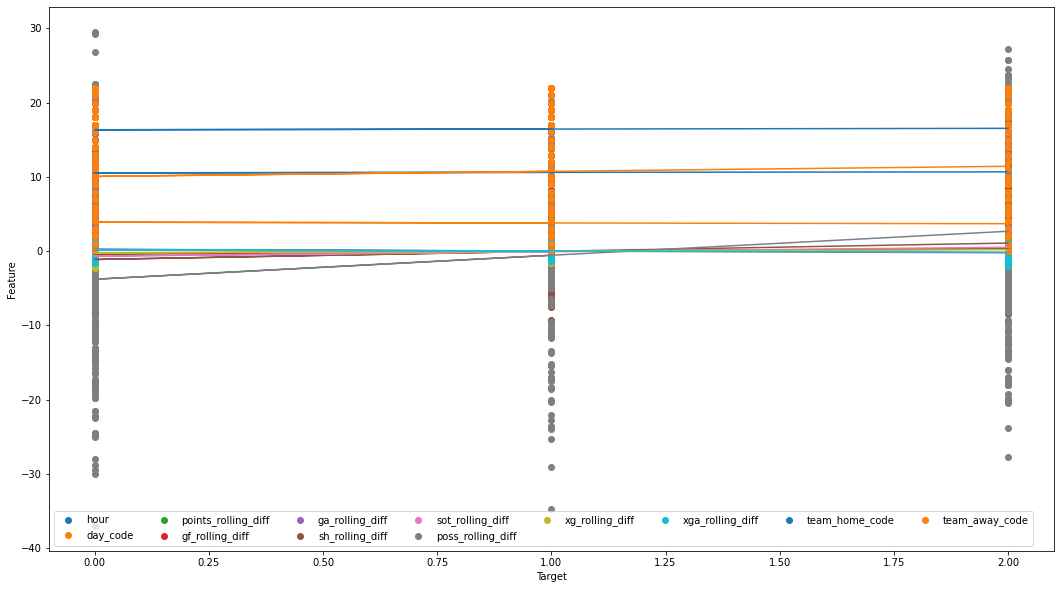

In [83]:
#viusalise general relationship between variables and target
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(figsize=(18, 10))
ax.set_xlabel('Target', fontsize=10)
ax.set_ylabel('Feature', fontsize='medium')

x=y_train

for i in range(len(X_train.columns)):
    y=X_train.iloc[:,i]
    plt.scatter(y=y, x=x, label=X_train.columns[i])
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x))
    
ax.legend(loc='best', ncol=8)

In [84]:
import xgboost as xgb
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK
import numpy as np

In [85]:
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['model']

In [86]:
from sklearn.metrics import accuracy_score

### XGBoost Regression

In [87]:
# xgbreg = xgb.XGBRegressor(objective="reg:squarederror", 
#                           random_state=42
#                          )

In [88]:
# xgbreg.fit(X_train, y_train)

In [89]:
# y_pred = xgbreg.predict(X_test)

In [90]:
# len(y_test)

In [91]:
# len(y_pred)

In [92]:
# len(X_train.columns)

In [93]:
# from sklearn.metrics import r2_score

In [94]:
# r2_score(y_test, y_pred)

In [95]:
# def objective_xgbreg(space):
    
#     model = xgb.XGBRegressor(objective="reg:squarederror", 
#                              max_depth=int(space['max_depth']),
#                              min_child_weight=int(space['min_child_weight']),
#                              n_estimators=int(space['n_estimators']),
#                              eval_metric="rmse",
#                              early_stopping_rounds=10,
#                              random_state=42
#                             )
    
#     evaluation=[(X_test, y_test)]
    
#     model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    
#     y_pred = model.predict(X_test)
#     score = r2_score(y_test, y_pred)
    
#     loss = 1 - score
    
#     return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [96]:
# space={'max_depth': hp.quniform("max_depth", 1, 18, 1),
#        'min_child_weight' : hp.quniform('min_child_weight', 0, 1000, 1),
#        'n_estimators': hp.quniform("n_estimators", 1, 1000, 1)
#       }

In [97]:
# xgbreg_trials = Trials()

In [98]:
# best_params_xgb = fmin(
#     fn=objective_xgbreg,
#     space=space,
#     algo=tpe.suggest,
#     trials=xgb_trials,
#     max_evals=1000)

In [99]:
# print(best_params_xgb)

In [100]:
# xgbreg_model = getBestModelfromTrials(xgbreg_trials)

In [101]:
# pred = xgbreg_model.predict(X_test)

In [102]:
# pred_rnd = np.around(pred)

In [103]:
# r2_score(y_test, pred)

In [104]:
# xgbreg_model

### XGBoost Classification

In [105]:
xgbclf = xgb.XGBClassifier(objective="multi:softmax", 
                          random_state=42
                         )

In [106]:
xgbclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

In [107]:
clf_pred = xgbclf.predict(X_test)

In [108]:
accuracy_score(y_test, clf_pred)

0.4338235294117647

In [109]:
def objective_xgbclf(space):
    
    model = xgb.XGBClassifier(objective="multi:softmax", 
                              num_class=3,
                              max_depth=int(space['max_depth']),
                              min_child_weight=int(space['min_child_weight']),
                              n_estimators=int(space['n_estimators']),
                              eval_metric="mlogloss",
                              early_stopping_rounds=10,
                              random_state=42
                             )
    
    evaluation=[(X_test, y_test)]
    
    model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    loss = 1-score
    
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [110]:
space={'max_depth': hp.quniform("max_depth", 1, 18, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 1000, 1),
       'n_estimators': hp.quniform("n_estimators", 1, 1000, 1)
      }

In [111]:
xgbclf_trials = Trials()

In [112]:
best_params_xgbclf = fmin(
    fn=objective_xgbclf,
    space=space,
    algo=tpe.suggest,
    trials=xgbclf_trials,
    max_evals=1000)

100%|██████████| 1000/1000 [03:18<00:00,  5.05trial/s, best loss: 0.4779411764705882]


In [113]:
best_params_xgbclf

{'max_depth': 12.0, 'min_child_weight': 40.0, 'n_estimators': 362.0}

In [114]:
xgbclf_model = getBestModelfromTrials(xgbclf_trials)

In [115]:
pred = xgbclf_model.predict(X_test)

In [116]:
pred

array([2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 0, 2,
       0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2,
       2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1,
       2, 2, 0, 2])

In [117]:
accuracy_score(y_test, pred)

0.5220588235294118

In [118]:
xgbclf_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=40,
              missing=nan, monotone_constraints='()', n_estimators=362,
              n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softmax', ...)

In [119]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

Text(0.5, 0, 'Feature Importance')

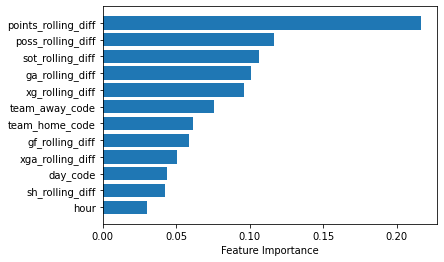

In [120]:
sort = xgbclf_model.feature_importances_.argsort()
plt.barh(X_train.columns[sort], xgbclf_model.feature_importances_[sort])
plt.xlabel("Feature Importance")

### Multi Classifier Model Test

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
names = ["Nearest Neighbors", "Logistic Regression","Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)

        # prediction_proba = clf.predict_proba(X_test)
        # logloss = log_loss(y_test,prediction_proba)
        # precision, recall, fscore, support = score(y_test, prediction)
        # conf_martrix = confusion_matrix(y_test, prediction)
        # clas_report = classification_report(y_test, prediction)

        print(name, accuracy)

### Linear SVM Optimisation

In [ ]:
lin_svm = SVC(kernel="linear", C=0.025, probability=True)

In [ ]:
lin_svm.fit(X_train, y_train)

In [ ]:
svm_pred = lin_svm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, svm_pred)

In [ ]:
def objective_svm(space):
    
    model = SVC(C=space['C'],
                gamma=float(space['gamma']),
                degree=int(space['degree']),
                kernel='linear',
                probability=True,
                random_state=42
               )
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    score = accuracy_score(y_test, pred)
    
    loss = 1 - score
    
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [ ]:
space={'C': hp.lognormal('C', 0, 1),
       'gamma' : hp.lognormal('gamma', 0, 1),
       'degree': hp.choice('degree', [1, 5])
      }

In [ ]:
svm_trials = Trials()

In [ ]:
best_params_svm = fmin(
    fn=objective_svm,
    space=space,
    algo=tpe.suggest,
    trials=svm_trials,
    max_evals=200)

In [ ]:
svm_model = getBestModelfromTrials(svm_trials)

In [ ]:
pred = svm_model.predict(X_test)

In [ ]:
pred

In [ ]:
accuracy_score(y_test, pred)

In [ ]:
svm_model